In [1]:
import os
import pandas as pd
import tifffile as tiff
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import curve_fit 
from scipy.optimize import OptimizeWarning


In [ ]:
"User's input"
'In here we add the coordinates of the libraries in which the files are saved and their names'
'In this current coding we are characterizing the 405 laser, not the 532nm this is just the'

# Extract the X and Y Scan
base_path_XY_Scan = './3-3-2025-405-90/XYZ3_1/Processed data'
sample_tif_XY_Scan = 'XYZ'
folder_path =  './3-3-2025-405-90/XYZ3_1/Processed data/Graphs'

#We will now analyze the XY Scan for every
x_range_um = 60
y_range_um = 10
z_range_um = 7
step_size_x_um = 10
step_size_y_um = 0.1
step_size_z_um = 0.7
pixel_size_um = 0.1065

z_start=0
x_start = 401 # in pixels
y_start = 166 # in pixels


wavelength = 0.405 #micro meters

step_size_x = step_size_x_um/pixel_size_um
step_size_y = step_size_y_um/pixel_size_um

x_range = x_range_um/pixel_size_um
y_range = y_range_um/pixel_size_um
all_displaced_intensities = []

Shift_x = x_range/2
Shift_y = y_range/2

"End User's input"



"End User's input"

In [3]:
# Get the csv file name for a given sample number
def get_csv_file_name(sample_number: str, files: list):
    for file_name in files:
        if sample_number in file_name and '.csv' in file_name and '.txt' not in file_name and '.ijm' not in file_name and '.tif' not in file_name:
            return file_name
    return 0

# Get the tif file name for a given sample number
def get_tif_file_name(sample_number:str, files:list):
    for file_name in files:
        if sample_number in file_name and '.tif' in file_name and '.txt' not in file_name and 'csv' not in file_name:
            return file_name
    return 0

def gaussian_func(xy, b, A, x0, y0, sigma_x, sigma_y):
    x, y = xy
    return b + A * np.exp(-((x - x0)**2 / (2 * sigma_x**2) + (y - y0)**2 / (2 * sigma_y**2)))

# Placeholder function to extract intensity from images based on coordinates
def extract_intensity(image, x, y):
    x = int(x)
    y = int(y)
    return image[y, x]  # Corrected the order to [y, x]

# Define a Gaussian function
def simple_gaussian(x, a, b, c):
    return a * np.exp(-((x - b) ** 2) / (2 * c ** 2))


# Define the Gaussian beam spot size function (in meters)
def gaussian_beam_spot_size(z, w_0):
    return w_0 * np.sqrt(1 + (z * wavelength / (np.pi * w_0**2))**2)



In [6]:
#mesh grid generator

files_XY_Scan = os.listdir(base_path_XY_Scan)
tif_file_XY_Scan = get_tif_file_name(sample_tif_XY_Scan, files_XY_Scan)
tif_file_XY_Scan_path = os.path.join(base_path_XY_Scan, tif_file_XY_Scan)
image_XY_Scan = tiff.imread(tif_file_XY_Scan_path)


particle = np.zeros (4)
#x_start, y_start, Z_0, intensity_specified = Coordinates_intensity[0]








In [8]:

x_start_shift = x_start -Shift_x
y_start_shift = y_start + Shift_y

print(x_start_shift)
print(y_start_shift)

119.3098591549296
212.94835680751174


In [9]:

all_displaced_intensities = []
particle_displaced_intensities = []


total_positions= 0

pixel_size_um = 0.1065
frame_number = 0
particle_displaced_intensities = []

radius_signal = 15

for z_step in range(int(z_range_um/step_size_z_um)):
    z = z_start + z_step * step_size_z_um
    
    for y_step in range(int(y_range_um/ step_size_y_um)):
        y = y_start_shift - y_step * step_size_y
        
        for x_step in range(int(x_range_um / step_size_x_um)):
            x = x_start_shift + x_step * step_size_x

            xmin_s = int(max(x - radius_signal, 0))
            xmax_s = int(x + radius_signal)
            ymin_s = int(max(y - radius_signal, 0))
            ymax_s = int(y + radius_signal)

                

            pixels_from_signal = image_XY_Scan[frame_number][ymin_s:ymax_s,xmin_s:xmax_s]
                
            intensity = np.sum(pixels_from_signal)
            "intensity = image_XY_Scan[frame_number][int(y)][int(x)]"
                
            particle_displaced_intensities.append((x, y, intensity, frame_number+1 , z ))
            frame_number += 1
            total_positions += 1
                
           
                
                

        
    
all_displaced_intensities.append(particle_displaced_intensities)
    



## Collect all rows into a list
combined_data = []
for index, particle_intensities in enumerate(all_displaced_intensities):
    for row in particle_intensities:
        combined_data.append({
            'Particle': index,
            'X': row[0],
            'Y': row[1],
            'Intensity': row[2],
            'Frame': row[3],
            'Z': row[4],
        })

df_combined = pd.DataFrame(combined_data)

# Optional: Reset the index if desired
df_combined.reset_index(drop=True, inplace=True)

# Collect Z and y0 values
z_y0_values = []
z_x0_values = [] 
fit_data_dict = {}
fwhm_x_values = []
fwhm_y_values = []
unique_Z_values = df_combined['Z'].unique()

# Save df_combined to a CSV file in the folder_path
df_combined.to_csv(os.path.join(folder_path, 'df_combined.csv'), index=False, mode='w')

print(f"Total positions iterated: {total_positions}")





Total positions iterated: 6000


In [10]:
image_XY_Scan.shape

(6000, 396, 894)

In [11]:
#Graphs and gaussian fits generators

graph_count = 9

for Z_value in unique_Z_values:
    # Filter the DataFrame based on the Z value
    df_combined_filtered = df_combined[df_combined['Z'] == Z_value]

    # Extract X, Y, and Intensity values
    X_data = df_combined_filtered['X'].values
    Y_data = df_combined_filtered['Y'].values

    X_data = X_data* pixel_size_um 
    Y_data = Y_data * -1 * pixel_size_um # Invert Y axis
    Intensity_data = df_combined_filtered['Intensity'].values

    # Plot the scatter plot for the current Z value
    plt.figure()
    plt.scatter(X_data, Y_data, c=Intensity_data, cmap='autumn', edgecolor='k', linewidths=0.7, s=30, alpha=1.0)
    plt.colorbar(label='Intensity')
    plt.xlabel('X (um)')
    plt.ylabel('Y (um)')
    plt.title(f' Intensity Meshgrid for Particle at Z = {Z_value:.1f} Epi Hilo illumination')
    plt.xlim(min(X_data) - 10, max(X_data) + 10)
    plt.ylim(min(Y_data) - 1, max(Y_data) + 1)
    plt.savefig(os.path.join(folder_path, f'2D_Scatter_Plot_for_Particle_at_Z_{Z_value:.1f}.png'))
    plt.close()

    
    initial_guess = (np.min(Intensity_data), np.max(Intensity_data), np.mean(X_data), np.mean(Y_data), 10, 10)
    
    
    
    # Fit the Gaussian function to the data with improved initial conditions
    try:
        popt, _ = curve_fit(gaussian_func, (X_data, Y_data), Intensity_data, p0=initial_guess, maxfev=1000000)
        
        x0= popt[2]
        y0 = popt[3]
        # Calculate FWHM
        fwhm_x = abs( popt[4])  # popt[4] is sigma_x
        print(fwhm_x)
        fwhm_y = 2*abs(  popt[5])  # popt[5] is sigma_y
        
        'np.sqrt(2 * np.log(2))'

        
    except RuntimeError as e:
        print(f"Fit did not converge for Z {Z_value}: {e}")
        continue

    # Generate meshgrid for x and y coordinates
    x_range = np.linspace(0, 1200* pixel_size_um,1200 )
    y_range = np.linspace(-1200* pixel_size_um, 0 ,1200 )  # Inverted y-range

    
    x_mesh, y_mesh = np.meshgrid(x_range, y_range)

    # Evaluate the Gaussian function using optimized parameters
    fit_data = gaussian_func((x_mesh, y_mesh), *popt).reshape(x_mesh.shape)
    fit_data_dict[Z_value] = fit_data 
    
    fwhm_x_values.append((Z_value,fwhm_x))
    fwhm_y_values.append((Z_value,fwhm_y))
    z_x0_values.append((Z_value, x0))
    z_y0_values.append((Z_value, y0)) 

        # Plot the Gaussian fit
    plt.figure()
    plt.imshow(fit_data, extent=(0, 1200* pixel_size_um , -1200* pixel_size_um , 0), cmap='autumn', origin='lower')
    plt.colorbar(label='Intensity')
    plt.xlabel('X (um)')
    plt.ylabel('Y (um)')
    plt.title(f'2D Gaussian Fit for Particle at Z {Z_value:.1f} Epi illumination')
    plt.xlim(min(X_data) - 10, max(X_data) + 10)
    plt.ylim(min(Y_data) - 10, max(Y_data) + 10)
    
    
    # Add FWHM to the plot
    
    plt.savefig(os.path.join(folder_path, f'2D_Gaussian_Fit_for_Particle_at_Z_{Z_value:.1f}.png'))

    plt.close()
    
    
    
    graph_count -= 1
    


18.032991748072916
18.96945284460012
16.816330717056395
11.598298067414904
14.436746411891392
15.718867015951492
14.98676418100896
16.734601588684548
17.79489038814953
19.014229915939328


The angle between the fitted line and the Z-axis is 24.55 degrees.


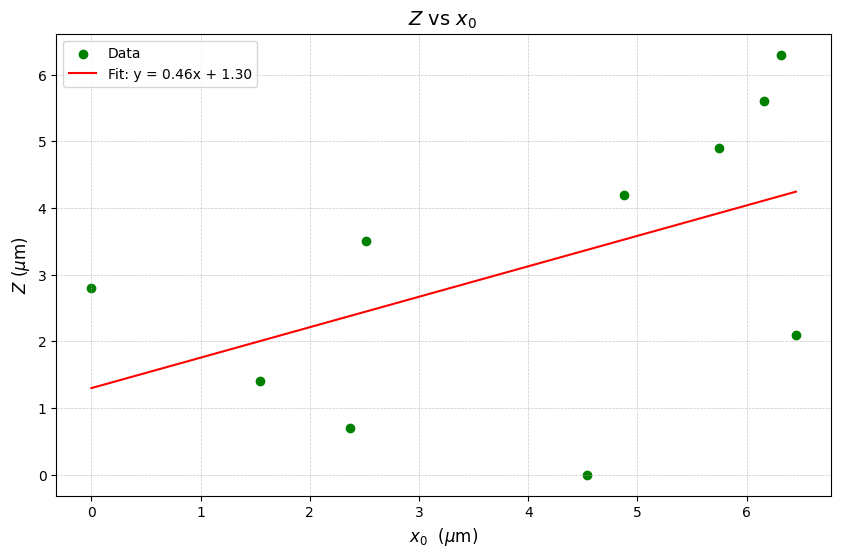

In [12]:
#Generate the Z vs x0 graph

# Create DataFrame
df_z_x0 = pd.DataFrame(z_x0_values, columns=['Z', 'x0'])
#df_z_x0 = df_z_x0[df_z_x0['Z'] >= 3]
# Shift the entire scatter plot by the minimum value of x0
min_x0 = df_z_x0['x0'].min()
df_z_x0['x0_shifted'] = df_z_x0['x0'] - min_x0

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot Z vs x0_shifted
ax.scatter(df_z_x0['x0_shifted'], df_z_x0['Z'], color='green', label='Data')
ax.set_ylabel(r'$Z$ ($\mu$m)', fontsize=12)  # Y-axis label with μm
ax.set_xlabel(r'$x_0$  ($\mu$m)', fontsize=12)  # X-axis label with μm
ax.set_title(r'$Z$ vs $x_0$ ', fontsize=14)  # Title with LaTeX
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Perform linear fit with intercept
coefficients = np.polyfit(df_z_x0['x0_shifted'], df_z_x0['Z'], 1)
slope, intercept = coefficients

# Calculate angle
min_Z = df_z_x0['Z'].min()
max_Z = df_z_x0['Z'].max()

delta_Z = max_Z - min_Z
delta_x0_shifted = slope * delta_Z

angle_rad = np.arctan(slope)
angle_deg = np.degrees(angle_rad)

print(f"The angle between the fitted line and the Z-axis is {angle_deg:.2f} degrees.")

# Plotting the fitted line only for the range from min_Z to max_Z
Z_range = np.linspace(df_z_x0['x0_shifted'].min(), df_z_x0['x0_shifted'].max(), 100)
ax.plot(Z_range, slope * Z_range + intercept, color='red', label=f'Fit: y = {slope:.2f}x + {intercept:.2f}')

ax.legend()


<Figure size 640x480 with 0 Axes>

The angle between the fitted line and the Z-axis is -67.42 degrees.


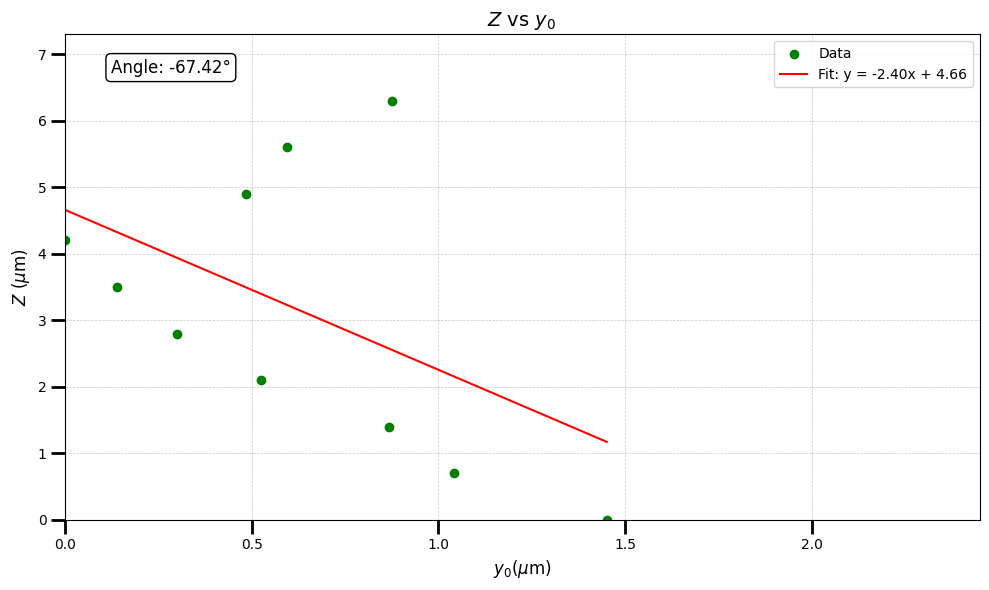

In [13]:
#Generates the Z vs Y0 graph and estimates the angle 

# Set the y-axis limit larger than the default
ax.set_ylim([min_Z, max_Z + 1])  # Adjust these values as needed for larger scale
ax.set_xlim([df_z_x0['x0_shifted'].min(), df_z_x0['x0_shifted'].max() ])

# Set thick ticks
ax.tick_params(axis='both', which='major', length=10, width=2)

plt.tight_layout()
plt.savefig(os.path.join(folder_path, 'Z_vs_x0_with_fit.png'), dpi=300)
plt.show()

# Create DataFrame
df_z_y0 = pd.DataFrame(z_y0_values, columns=['Z', 'y0'])
#df_z_y0 = df_z_y0[df_z_y0['Z'] <= 9]
# Shift the entire scatter plot by the minimum value of y0
min_y0 = df_z_y0['y0'].min()
df_z_y0['y0_shifted'] = df_z_y0['y0'] - min_y0

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot Z vs y0_shifted
ax.scatter(df_z_y0['y0_shifted'], df_z_y0['Z'], color='green', label='Data')
ax.set_ylabel(r'$Z$ ($\mu$m)', fontsize=12)  # Y-axis label with μm
ax.set_xlabel(r'$y_0$($\mu$m)', fontsize=12)  # X-axis label with μm
ax.set_title(r'$Z$ vs $y_0$ ', fontsize=14)  # Title with LaTeX
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Perform linear fit with intercept
coefficients = np.polyfit(df_z_y0['y0_shifted'], df_z_y0['Z'], 1)
slope, intercept = coefficients

# Calculate angle
min_Z = df_z_y0['Z'].min()
max_Z = df_z_y0['Z'].max()

max_y0 = df_z_y0['y0_shifted'].max()
delta_Z = max_Z - min_Z
delta_y0_shifted = slope * delta_Z

angle_rad = np.arctan(slope)
angle_deg = np.degrees(angle_rad)

print(f"The angle between the fitted line and the Z-axis is {angle_deg:.2f} degrees.")

# Plotting the fitted line only for the range from min_Z to max_Z
Z_range = np.linspace(df_z_y0['y0_shifted'].min(), df_z_y0['y0_shifted'].max(), 100)
ax.plot(Z_range, slope * Z_range + intercept, color='red', label=f'Fit: y = {slope:.2f}x + {intercept:.2f}')

ax.legend()
# Add the angle text to the top left of the plot
angle_text = f"Angle: {angle_deg:.2f}°"
ax.text(0.05, 0.95, angle_text, transform=ax.transAxes,
        fontsize=12, verticalalignment='top', horizontalalignment='left',
        bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))

# Set the y-axis limit larger than the default
ax.set_ylim([min_Z, max_Z + 1])  # Adjust these values as needed for larger scale
ax.set_xlim([min_Z, max_y0 + 1])

# Set thick ticks
ax.tick_params(axis='both', which='major', length=10, width=2)

plt.tight_layout()
plt.savefig(os.path.join(folder_path, 'Z_vs_y0_with_fit.png'), dpi=300)
plt.show()


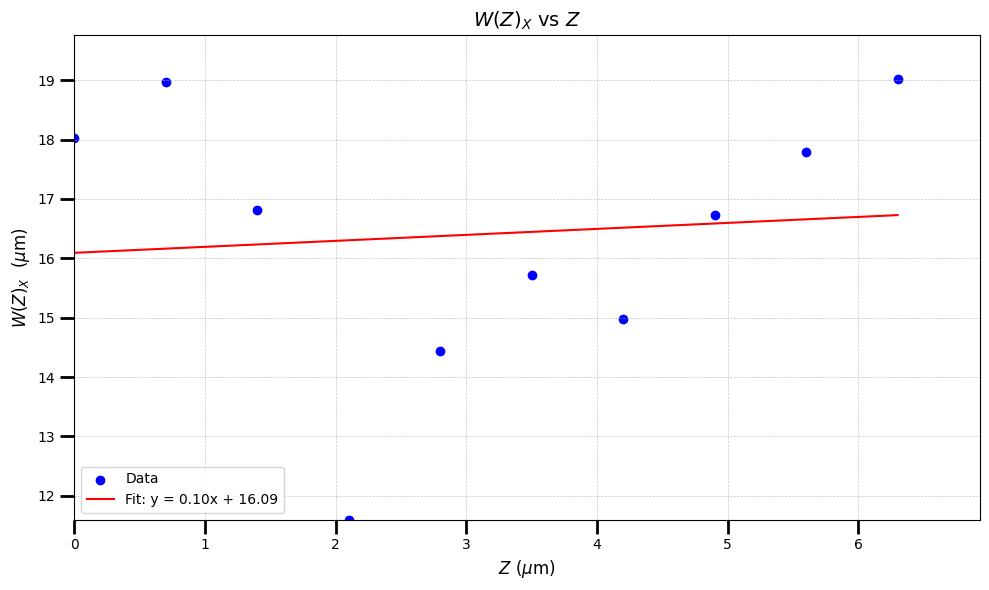

In [14]:
#FWHM's graphs

# Create DataFrame for FWHM values
df_fwhm_x = pd.DataFrame(fwhm_x_values, columns=['Z', 'fwhm_x'])
df_fwhm_y = pd.DataFrame(fwhm_y_values, columns=['Z', 'fwhm_y'])

# Plot Z vs fwhm_x
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(df_fwhm_x['Z'], df_fwhm_x['fwhm_x'], color='blue', label='Data')
ax.set_xlabel(r'$Z$ ($\mu$m)', fontsize=12)  # X-axis label with μm
ax.set_ylabel(r'$W(Z)_X$  ($\mu$m)', fontsize=12)  # Y-axis label with μm
ax.set_title(r'$W(Z)_X$ vs $Z$ ', fontsize=14)  # Title with LaTeX
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Perform linear fit with intercept
coefficients_fwhm_x = np.polyfit(df_fwhm_x['Z'], df_fwhm_x['fwhm_x'], 1)
slope_fwhm_x, intercept_fwhm_x = coefficients_fwhm_x

# Plotting the fitted line only for the range from min_Z to max_Z
Z_range_fwhm_x = np.linspace(df_fwhm_x['Z'].min(), df_fwhm_x['Z'].max(), 100)
ax.plot(Z_range_fwhm_x, slope_fwhm_x * Z_range_fwhm_x + intercept_fwhm_x, color='red', label=f'Fit: y = {slope_fwhm_x:.2f}x + {intercept_fwhm_x:.2f}')

ax.legend()

# Set the axis limits with a margin
ax.set_xlim([df_fwhm_x['Z'].min(), df_fwhm_x['Z'].max() + (df_fwhm_x['Z'].max() - df_fwhm_x['Z'].min()) * 0.1])
ax.set_ylim([df_fwhm_x['fwhm_x'].min(), df_fwhm_x['fwhm_x'].max() + (df_fwhm_x['fwhm_x'].max() - df_fwhm_x['fwhm_x'].min()) * 0.1])

# Set thick ticks
ax.tick_params(axis='both', which='major', length=10, width=2)

plt.tight_layout()
plt.savefig(os.path.join(folder_path, 'FWHM_x_vs_Z_with_fit.png'), dpi=300)
plt.show()


6.3e-06
2.367109453019688e-06


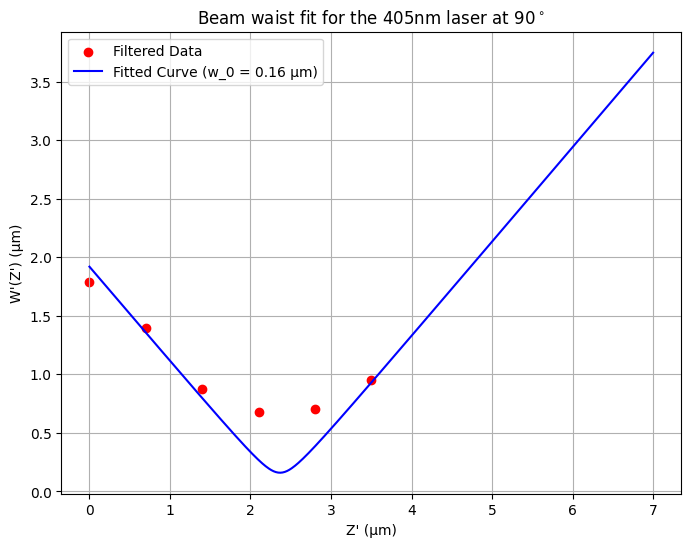

Fitted beam waist (w_0): 0.16 µm
Rayleigh range (z_R): 0.23 µm
Angle spread: 90.00 degrees


In [15]:
# Single Beam waist calculator
def gaussian_beam_spot_size(z, w_0, z_shift):
    return w_0 * np.sqrt(1 + ((z - z_shift) * wavelength / (np.pi * w_0**2))**2)

# Constants
n = 1.335  # Refractive index
wavelength = 0.405e-6  # Wavelength in meters
angle_rad = (np.pi) / 2  # 90 degrees in radians
sin_angle = np.sin(np.radians(angle_deg))

# Original FWHM arrays without mirroring or sorting
fwhm_y = df_fwhm_y['fwhm_y'] * 1e-6 * np.sin(angle_rad)  # Convert to meters and transform y to y'
fwhm_Z = (df_fwhm_y['Z'] * 1e-6) / np.sin(angle_rad)     # Convert to meters and transform Z to Z'
print(max(fwhm_Z))

# Identify exact Z values to exclude
z_value_0 = fwhm_Z.iloc[-1]
z_value_1um = fwhm_Z.iloc[-2]
z_value_2um = fwhm_Z.iloc[-3]
z_value_3um = fwhm_Z.iloc[-4]

# Apply mask to exclude unwanted data points
mask = (fwhm_Z != z_value_0) & (fwhm_Z != z_value_1um) & (fwhm_Z != z_value_2um) & (fwhm_Z != z_value_3um)
fwhm_y_filtered = fwhm_y[mask]
fwhm_Z_filtered = fwhm_Z[mask]

# Initial guess for fitting
initial_guess_w0 = fwhm_y_filtered.min() * 1e-6
initial_guess_z_shift = 0 * 1e-6

# Perform the curve fitting
popt_beam, pcov_beam = curve_fit(gaussian_beam_spot_size, fwhm_Z_filtered, fwhm_y_filtered, 
                                 p0=[initial_guess_w0, initial_guess_z_shift], maxfev=50000)

# Extract fitted parameters
fitted_w0 = popt_beam[0]
fitted_z_shift = popt_beam[1]
print(fitted_z_shift)

# Calculate Rayleigh range and angle spread
z_R = fitted_w0 * np.sqrt(2)
angle_spread = np.arctan((wavelength / (np.pi * fitted_w0)) * 1e6)

# Convert to micrometers for plotting
z_R_um = z_R * 1e6
angle_spread_deg = np.degrees(angle_spread)

# Generate smooth curve for plotting
maxim = 7 * 1e-6
z_smooth = np.linspace(fwhm_Z_filtered.min(), maxim, 500)
fitted_fwhm_y_smooth = gaussian_beam_spot_size(z_smooth, fitted_w0, fitted_z_shift)

# Convert all to micrometers
fwhm_y_um = fwhm_y_filtered * 1e6
fwhm_Z_um = fwhm_Z_filtered * 1e6
fitted_fwhm_y_smooth_um = fitted_fwhm_y_smooth * 1e6
z_smooth_um = z_smooth * 1e6
fitted_w0_um = fitted_w0 * 1e6
z_R_um = fitted_w0 * np.sqrt(2) * 1e6

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(fwhm_Z_um, fwhm_y_um, color='red', label='Filtered Data', marker='o')
plt.plot(z_smooth_um, fitted_fwhm_y_smooth_um, color='blue', label=f'Fitted Curve (w_0 = {fitted_w0_um:.2f} µm)')

plt.xlabel('Z\' (µm)')
plt.ylabel('W\'(Z\') (µm)')
plt.title(r'Beam waist fit for the 405nm laser at 90$^\circ$')
plt.legend()
plt.grid(True)

plt.savefig(os.path.join(folder_path, 'Beams profile.png'), dpi=300)
plt.show()

# Print calculated values
print(f"Fitted beam waist (w_0): {fitted_w0_um:.2f} µm")
print(f"Rayleigh range (z_R): {z_R_um:.2f} µm")
print(f"Angle spread: {angle_spread_deg:.2f} degrees")


6.3e-06
2.367109453019688e-06
hi
0    0.000000e+00
1    7.000000e-07
2    1.400000e-06
3    2.100000e-06
4    2.800000e-06
5    3.500000e-06
Name: Z, dtype: float64


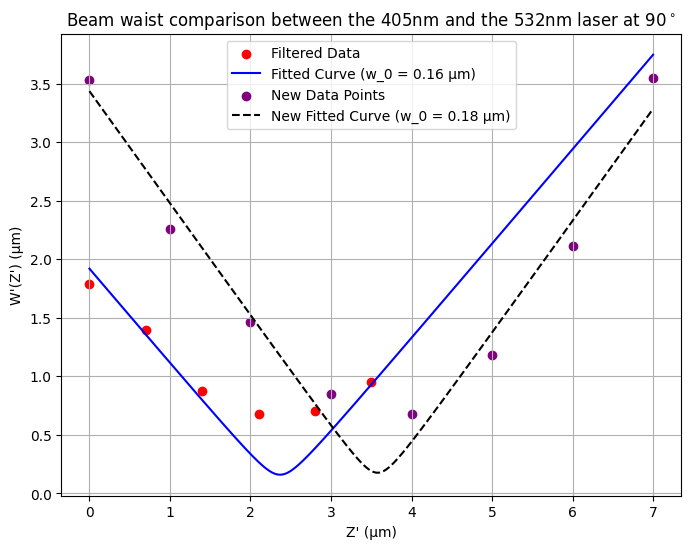

Fitted beam waist (w_0): 0.16 µm
Rayleigh range (z_R): 0.23 µm
Angle spread: 90.00 degrees


In [16]:
# Double Beam waist calculator
def gaussian_beam_spot_size(z, w_0, z_shift):
    return w_0 * np.sqrt(1 + ((z - z_shift) * wavelength / (np.pi * w_0**2))**2)
# Constants
n = 1.335  # Refractive index
wavelength = 0.405e-6  # Wavelength in meters (adjust this value based on your actual wavelength)
angle_rad = abs(angle_rad)
angle_rad = (np.pi)/2
sin_angle = np.sin(np.radians(angle_deg))

# Original FWHM arrays without mirroring or sorting
fwhm_y = df_fwhm_y['fwhm_y'] * 1e-6 * np.sin(angle_rad)  # Convert to meters and transform y to y'
fwhm_Z = (df_fwhm_y['Z'] * 1e-6) / np.sin(angle_rad)     # Convert to meters and transform Z to Z'
print(max(fwhm_Z))



# Find the exact values to filter out
z_value_0 = fwhm_Z.iloc[-1]  # First value (Z = 0)
z_value_1um = fwhm_Z.iloc[-2]  # Second value (Z = 1 µm)
z_value_2um = fwhm_Z.iloc[-3]
z_value_3um = fwhm_Z.iloc[-4]
#z_value_4um = fwhm_Z.iloc[-5]

#mask = (fwhm_Z > 0) & (fwhm_Z < 10e-6)  # Adjust this as per your data requirements
 # Filter Z values greater than 3 and less than 6

# Exclude the data points using the exact values identified
mask = (fwhm_Z != z_value_0) & (fwhm_Z != z_value_1um)&(fwhm_Z != z_value_2um  )&(fwhm_Z != z_value_3um  )#&(fwhm_Z != z_value_4um  )
fwhm_y_filtered = fwhm_y[mask]
fwhm_Z_filtered = fwhm_Z[mask]
"""
fwhm_y_filtered = fwhm_y
fwhm_Z_filtered = fwhm_Z
"""

# Initial guess for w_0 (use the minimum value of fwhm_y as an estimate)
initial_guess_w0 = fwhm_y_filtered.min() * 1e-6  # Convert from micrometers to meters
initial_guess_z_shift = 0*1e-6
# Perform the curve fitting
popt_beam, pcov_beam = curve_fit(gaussian_beam_spot_size, fwhm_Z_filtered, fwhm_y_filtered, 
                                 p0=[initial_guess_w0,initial_guess_z_shift], maxfev=50000)

# Extract the fitted w_0
fitted_w0 = popt_beam[0]
fitted_z_shift = popt_beam[1]
print(fitted_z_shift)
# Calculate the Rayleigh range (z_R) and angle spread (θ)
z_R =  fitted_w0 * np.sqrt(2)  # Rayleigh range in meters
angle_spread = np.arctan((wavelength / (np.pi * fitted_w0)) * 1e6)  # Angle spread in radians

# Convert to micrometers for consistency with the plot
z_R_um = z_R * 1e6  # Convert Rayleigh range to micrometers
angle_spread_deg = np.degrees(angle_spread)  # Convert angle spread to degrees

# Generate fitted values for the beam spot size based on the filtered Z array
fitted_fwhm_y = gaussian_beam_spot_size(fwhm_Z_filtered, fitted_w0,fitted_z_shift)
maxim = 7*1e-6
z_smooth = np.linspace(fwhm_Z_filtered.min(), maxim , 500)  # 500 points for smoothness
fitted_fwhm_y_smooth = gaussian_beam_spot_size(z_smooth, fitted_w0, fitted_z_shift)  # Compute smooth fit
print('hi')
print(fwhm_Z_filtered)
# Convert values for plotting
fwhm_y_um = fwhm_y_filtered * 1e6  # Convert to micrometers
fwhm_Z_um = fwhm_Z_filtered * 1e6  # Convert to micrometers
fitted_fwhm_y_smooth_um = fitted_fwhm_y_smooth * 1e6  # Convert to micrometers
z_smooth_um = z_smooth * 1e6  # Convert to micrometers
fitted_w0_um = fitted_w0 * 1e6  # Convert to micrometers
z_R_um = fitted_w0 * np.sqrt(2) * 1e6  # Convert Rayleigh range to micrometers



# New dataset
fwhm_Z_um_new = np.array([0, 1, 2, 3, 4, 5, 6, 7])
fwhm_y_um_new = np.array([3.528, 2.2603, 1.462, 0.8526, 0.6763, 1.185158, 2.112557, 3.5454])  # In micrometers

# Convert to meters
fwhm_Z_new = fwhm_Z_um_new * 1e-6
fwhm_y_new = fwhm_y_um_new * 1e-6

# Initial guess for w_0
initial_guess_w0_new = fwhm_y_new.min()
initial_guess_z_shift_new = 0 * 1e-6

# New wavelength for this dataset
wavelength = 0.532e-6  # In meters

# Perform curve fitting
popt_beam_new, _ = curve_fit(gaussian_beam_spot_size, fwhm_Z_new, fwhm_y_new, 
                                 p0=[initial_guess_w0,initial_guess_z_shift], maxfev=50000)

# Extract fitted parameters
fitted_w0_new = popt_beam_new[0]
fitted_z_shift_new = popt_beam_new[1]
maxim = 7*1e-6
# Generate smooth fitted curve
z_smooth_new = np.linspace(fwhm_Z_new.min(),maxim , 500)  # 500 points for smoothness
fitted_fwhm_y_smooth_new = gaussian_beam_spot_size(z_smooth_new, fitted_w0_new, fitted_z_shift_new)

# Convert values for plotting
fitted_fwhm_y_smooth_um_new = fitted_fwhm_y_smooth_new * 1e6  # Convert to micrometers
z_smooth_um_new = z_smooth_new * 1e6  # Convert to micrometers
fitted_w0_um_new = fitted_w0_new * 1e6  # Convert to micrometers
z_R_um_new = fitted_w0_new * np.sqrt(2) * 1e6  # Convert Rayleigh range to micrometers



# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(fwhm_Z_um, fwhm_y_um, color='red', label='Filtered Data', marker='o')
plt.plot(z_smooth_um, fitted_fwhm_y_smooth_um, color='blue', label=f'Fitted Curve (w_0 = {fitted_w0_um:.2f} µm)')
plt.scatter(fwhm_Z_um_new, fwhm_y_um_new, color='purple', label='New Data Points', marker='o')
plt.plot(z_smooth_um_new, fitted_fwhm_y_smooth_um_new, color='black', linestyle='--',label=f'New Fitted Curve (w_0 = {fitted_w0_um_new:.2f} µm)')

plt.xlabel('Z\' (µm)')
plt.ylabel('W\'(Z\') (µm)')
plt.title(r'Beam waist comparison between the 405nm and the 532nm laser at 90$^\circ$')
plt.legend()
plt.grid(True)

plt.savefig(os.path.join(folder_path,'Beams profile.png'), dpi=300)

# Show the plot
plt.show()

# Print calculated values
print(f"Fitted beam waist (w_0): {fitted_w0_um:.2f} µm")
print(f"Rayleigh range (z_R): {z_R_um:.2f} µm")
print(f"Angle spread: {angle_spread_deg:.2f} degrees")

In [47]:
import numpy as np
import pyvista as pv
from matplotlib import colors as mcolors

# --- Gaussian function ---
def gaussian_2d(x, y, sigma_x, sigma_y):
    return np.exp(-((x**2)/(2*sigma_x**2) + (y**2)/(2*sigma_y**2)))

# --- Inputs ---
power_at_config = 2.03E3  # total beam power in Watts
sigma_x = np.average(fwhm_x_values)  # µm, already σ (not FWHM)
sigma_y_array = fitted_fwhm_y_smooth * 1E6 / 2  # convert FWHM in meters to σ in µm

# --- Grid setup ---
grid_size = 800

# Define separate extents
x_extent = 2 * sigma_x  # ≈ ±51 µm
y_extent = 3 * max(sigma_y_array)  # ≈ ±4.75 µm

# Updated grid (asymmetric beam)
x_range = np.linspace(-x_extent, x_extent, grid_size)
y_range = np.linspace(-y_extent, y_extent, grid_size)
X, Y = np.meshgrid(x_range, y_range)

# Recalculate spacing per voxel
voxel_spacing_x = (x_range[-1] - x_range[0]) / grid_size
voxel_spacing_y = (y_range[-1] - y_range[0]) / grid_size
z_spacing_um = 7 / len(sigma_y_array)  # Z-spacing in µm based on total depth

# --- Generate power density stack ---
gaussian_stack = np.array([
    (power_at_config / (2 * np.pi * sigma_x * sigma_y_array[4])) * gaussian_2d(X, Y, sigma_x, sigma_y)
    for sigma_y in sigma_y_array
])

# Transpose to (X, Y, Z) for PyVista
data_pv = pv.wrap(gaussian_stack.transpose(2, 1, 0))

# --- Custom colormap: black to laser green (#00FF00) ---
laser_green_rgb = (0, 1, 0)  # RGB in [0,1] format
custom_green_cmap = mcolors.LinearSegmentedColormap.from_list(
    "laser_green", [(0, 0, 0), laser_green_rgb]
)
n_colors = 256
green_hex_colors = [mcolors.to_hex(c) for c in custom_green_cmap(np.linspace(0, 1, n_colors))]

# --- Visualization ---
p = pv.Plotter(notebook=False)

p.add_volume(
    data_pv,
    cmap=green_hex_colors,
    opacity="sigmoid",
    scalar_bar_args={"title": "Power Density (µW/µm²)"}
)

# --- Add Half-Cell Model (centered correctly in volume) ---
cell_rx = 285  # intended to be along the real X-axis
cell_ry = 300  # intended to be along the real Y-axis
cell_rz = 90   # intended to be along the real Z-axis

# Because of transpose(2, 1, 0), the axis mapping is:
# PyVista X → real Z
# PyVista Y → real Y
# PyVista Z → real X

# Compute beam center in real coordinates
center_x = (x_range[0] + x_range[-1]) / 2  # real X
center_y = (y_range[0] + y_range[-1]) / 2  # real Y
center_z = (z_spacing_um * len(sigma_y_array)) / 2  # real Z

# Apply noticeable offset to test movement
offset_z =400  # along PyVista X → real Z
offset_y = 400  # along PyVista Y → real Y
offset_x = 0  # along PyVista Z → real X

# Apply shifted position
shifted_position = (center_z + offset_z, center_y + offset_y, center_x + offset_x)

ellipsoid = pv.ParametricEllipsoid(cell_rz, cell_ry, cell_rx).translate(shifted_position)
half_cell = ellipsoid.clip(normal='z', origin=shifted_position, invert=False)

p.add_mesh(half_cell, color='lightpink', opacity=1, label='Toy Cell')

# Axis labeling and scaling
p.show_grid(color='black', use_3d_text=False,
            xlabel='X (µm)', ylabel='Y (µm)', zlabel='Z (µm)')

p.set_scale(xscale=voxel_spacing_x, yscale=voxel_spacing_y, zscale=z_spacing_um)
p.camera_position = 'yz'
p.add_axes()

p.show()


In [18]:
# import numpy as np
# import pyvista as pv
# from matplotlib.cm import viridis

# # --- Gaussian function ---
# def gaussian_2d(x, y, sigma_x, sigma_y):
#     return np.exp(-((x**2)/(2*sigma_x**2) + (y**2)/(2*sigma_y**2)))

# # --- Inputs ---
# power_at_config = 2.03E3  # Total power of the beam (W)
# sigma_x = np.average(fwhm_x_values)  # µm
# sigma_y_array = fitted_fwhm_y_smooth * 1E6 / 2  # FWHM in meters → σ in µm

# # --- Grid setup ---
# grid_size = 800
# x_extent = 2 * sigma_x
# y_extent = 3 * max(sigma_y_array)

# x_range = np.linspace(-x_extent, x_extent, grid_size)
# y_range = np.linspace(-y_extent, y_extent, grid_size)
# X, Y = np.meshgrid(x_range, y_range)

# voxel_spacing_x = (x_range[-1] - x_range[0]) / grid_size
# voxel_spacing_y = (y_range[-1] - y_range[0]) / grid_size
# z_spacing_um = 7 / len(sigma_y_array)  # total depth = 7 µm

# # --- Step 1: Generate full-resolution Gaussian stack ---
# gaussian_stack = np.array([
#     (power_at_config / (2 * np.pi * sigma_x * sigma_y_array[4])) * gaussian_2d(X, Y, sigma_x, sigma_y)
#     for sigma_y in sigma_y_array
# ])  # shape = (Z, Y, X)

# # --- Step 2: Compute total power per plane ---
# voxel_area = voxel_spacing_x * voxel_spacing_y  # µm²
# power_per_plane = gaussian_stack.sum(axis=(1, 2)) * voxel_area  # W

# # --- Step 3: Compute power density per plane (W/µm²) ---
# plane_area = (x_range[-1] - x_range[0]) * (y_range[-1] - y_range[0])  # µm²
# avg_power_density = power_per_plane / plane_area  # one value per plane

# # --- Step 4: Build volume where each plane is filled with its average power density ---
# uniform_stack = np.stack([
#     np.full((grid_size, grid_size), value)
#     for value in avg_power_density
# ])  # shape = (Z, Y, X)

# # --- Step 5: Visualize as 3D volume with flat-colored planes ---
# volume_data = pv.wrap(uniform_stack.transpose(2, 1, 0))  # shape = (X, Y, Z)

# p = pv.Plotter(notebook=False)
# p.add_volume(
#     volume_data,
#     cmap=viridis,
#     opacity="linear",
#     scalar_bar_args={"title": "Avg. Power Density (W/µm²)"}
# )
# p.show_grid(color='black', use_3d_text=False,
#             xlabel='X (µm)', ylabel='Y (µm)', zlabel='Z (µm)')
# p.set_scale(
#     xscale=voxel_spacing_x,
#     yscale=voxel_spacing_y,
#     zscale=z_spacing_um
# )
# p.camera_position = 'yz'
# p.add_axes()
# p.show()
